In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [8]:
#Get data from Kaggle: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
file_path = os.path.join('Stocks', 'HPQ.us.txt')
df = pd.read_csv(file_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close'], parse_dates=['Date'])
df

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385
...,...,...,...,...,...
12070,2017-11-06,21.47000,21.53000,21.38000,21.44000
12071,2017-11-07,21.47000,21.47000,21.32000,21.38000
12072,2017-11-08,21.34000,21.47000,21.24000,21.42000
12073,2017-11-09,21.27000,21.40000,21.15000,21.34000


### Normalize the data

In [3]:
# Split the data into training and testing datasets
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:] 

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))

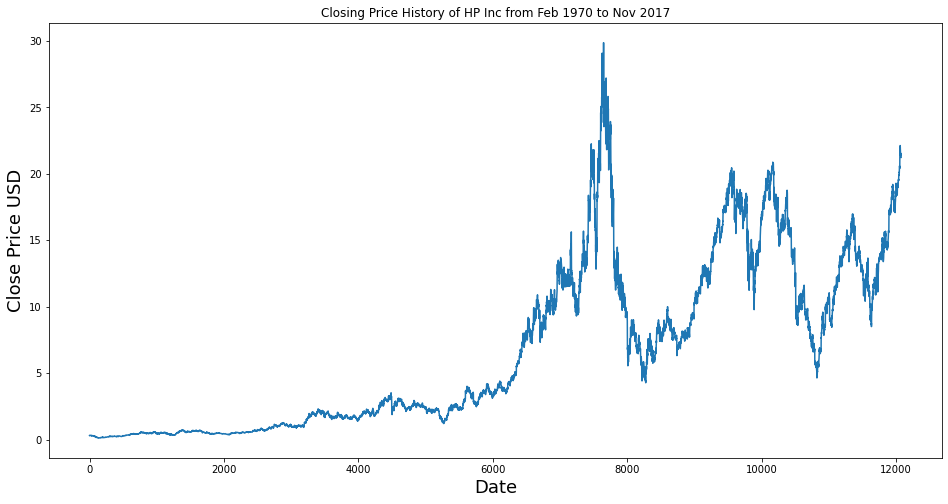

In [5]:
plt.figure(figsize = (16, 8))
plt.title("Closing Price History of HP Inc from Feb 1970 to Nov 2017")
plt.plot(df['Close'], label = "Stock price")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD", fontsize = 18)
plt.show()

In [6]:
no_unrollings = 10  # Number of steps you look into the future
days = 30  # The number of days used as the prediction dataset to forecast the future
x_train, y_train = [], []  # x is data feature and y is label, next stock price
for i in range(days, len(scaled_data) - no_unrollings):
    x_train.append(scaled_data[i - days : i, 0])
    y_train.append(scaled_data[i + no_unrollings, 0])
assert len(x_train) == len(y_train)
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 

In [7]:
real_prices = test_data['Close']
total_data = pd.concat((train_data['Close'], test_data['Close']), axis=0)
model_test = total_data[len(total_data) - len(test_data) - no_unrollings:].values
model_test = model_test.reshape(-1, 1)
model_test = scaler.transform(model_test)

In [8]:
x_test = []
for i in range(days, len(model_test)):
    x_test.append(model_test[i-days : i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test_data['Close'].values[:len(x_test)]
assert len(x_test) == len(y_test)

### Create LSTM model

In [9]:
model = Sequential()
# The 1st layer
model.add(LSTM(units = 50, return_sequences= True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2)) # Add dropout to increase efficiency and avoid overfitting

# The 2nd layer
model.add(LSTM(units = 50, return_sequences= True))
model.add(Dropout(0.2))

# The 3rd layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units= 1))

# Compile the model
model.summary()
model.compile(optimizer = 'adam', loss = 'mean_squared_error',  metrics=['mean_squared_error', 'mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

### Training the model

In [10]:
checkpointer = ModelCheckpoint(filepath= 'best_weight.hdf5', verbose= 2, save_best_only= True)
model.fit(x_train, y_train, epochs= 25, batch_size = 32, validation_data=(x_test, y_test),callbacks= [checkpointer] )

Epoch 1/25
301/301 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026 - mae: 0.0263
Epoch 1: val_loss improved from inf to 184.97662, saving model to best_weight.hdf5
301/301 [==============================] - 8s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mae: 0.0263 - val_loss: 184.9766 - val_mean_squared_error: 184.9766 - val_mae: 13.1264
Epoch 2/25
300/301 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mae: 0.0197
Epoch 2: val_loss did not improve from 184.97662
301/301 [==============================] - 5s 15ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mae: 0.0197 - val_loss: 185.3957 - val_mean_squared_error: 185.3957 - val_mae: 13.1429
Epoch 3/25
300/301 [============================>.] - ETA: 0s - loss: 9.9819e-04 - mean_squared_error: 9.9819e-04 - mae: 0.0184
Epoch 3: val_loss did not improve from 184.97662
301/301 [==============================] - 5s 15ms/step - loss: 9.9765e-0

Epoch 23/25
299/301 [============================>.] - ETA: 0s - loss: 7.4757e-04 - mean_squared_error: 7.4757e-04 - mae: 0.0172
Epoch 23: val_loss did not improve from 184.23108
301/301 [==============================] - 5s 16ms/step - loss: 7.4712e-04 - mean_squared_error: 7.4712e-04 - mae: 0.0173 - val_loss: 184.8872 - val_mean_squared_error: 184.8872 - val_mae: 13.1229
Epoch 24/25
301/301 [==============================] - ETA: 0s - loss: 7.9004e-04 - mean_squared_error: 7.9004e-04 - mae: 0.0177
Epoch 24: val_loss did not improve from 184.23108
301/301 [==============================] - 5s 15ms/step - loss: 7.9004e-04 - mean_squared_error: 7.9004e-04 - mae: 0.0177 - val_loss: 185.5184 - val_mean_squared_error: 185.5184 - val_mae: 13.1454
Epoch 25/25
301/301 [==============================] - ETA: 0s - loss: 7.5015e-04 - mean_squared_error: 7.5015e-04 - mae: 0.0174
Epoch 25: val_loss did not improve from 184.23108
301/301 [==============================] - 5s 15ms/step - loss: 7.501

### Prediction

In [11]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

75/75 [==============================] - 1s 5ms/step


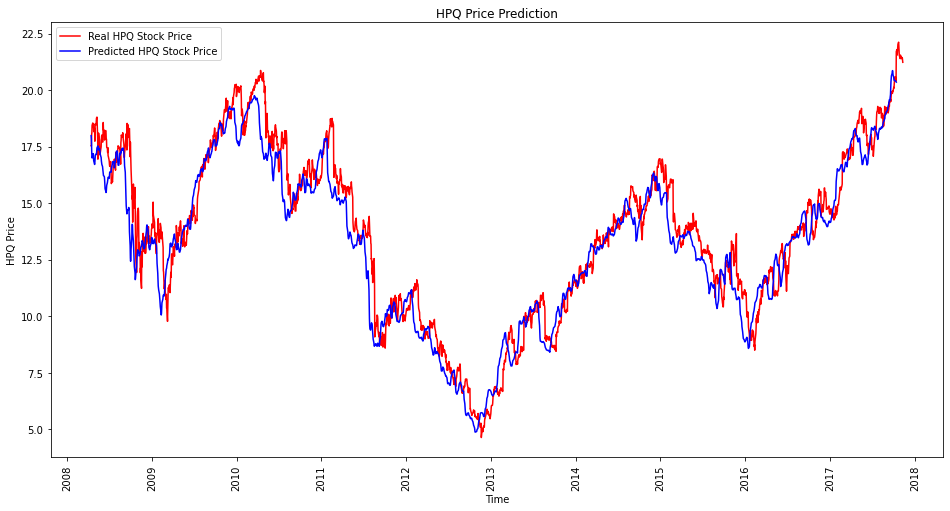

In [12]:
plt.figure(figsize = (16, 8))
plt.plot(df.loc[train_size:, 'Date'], real_prices, color='red', label='Real HPQ Stock Price')
plt.plot(df.loc[train_size:train_size+len(predicted_prices)-1, 'Date'], predicted_prices, color='blue', label='Predicted HPQ Stock Price')
plt.title('HPQ Price Prediction')
plt.xlabel('Time')
plt.ylabel('HPQ Price')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [13]:
real_data = np.array([model_test[len(model_test) + 1 - no_unrollings:len(model_test + 1), 0]])
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
predicted_p = model.predict(real_data)
predicted_p = scaler.inverse_transform(predicted_p)
print(f"Tommorrow predicted price: ${predicted_p[0][0]}")

1/1 [==============================] - 1s 564ms/step
Tommorrow predicted price: $20.17287826538086
